## 数据清洗

In [36]:
#先导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
#读取数据
df = pd.read_csv('./data/sh600132.csv')
 
#查看描述统计
df.describe().style.background_gradient(cmap = 'Oranges')

,open,high,low,close,old_close,volume,amount,active_value,total_value
count,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000
mean,37.248133,38.071561,36.500476,37.308433,37.293123,3937029.426638,155839979.093823,15012504542.588766,16271645986.629221
std,36.207685,37.078078,35.390398,36.254985,36.254894,5743958.925658,228945773.517893,19246225075.687866,18523934902.380840
min,6.490000,6.890000,6.450000,6.550000,5.540000,9800.000000,116644.000000,324000000.000000,1413000000.000000
25%,15.700000,15.940000,15.490000,15.720000,15.715000,923722.000000,13165877.500000,1078220000.000000,3609671000.000000
50%,21.500000,21.900000,21.040000,21.560000,21.560000,2728464.000000,74908041.000000,7632225792.000000,8798596380.000000
75%,43.580000,44.750000,42.550000,43.760000,43.675000,4689830.000000,198805554.000000,20278393196.000000,20278393196.000000
max,204.000000,209.990000,201.020000,205.030000,205.030000,93487135.000000,2992033108.000000,99228614726.000000,99228614726.000000


## 添加股票指标

#### MADC

In [37]:
# 计算12日EMA和26日EMA
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()

# 计算 DIF（快线）
df["DIF"] = df["EMA12"] - df["EMA26"]

# 计算 DEA（慢线），即 DIF 的 9 日 EMA
df["DEA"] = df["DIF"].ewm(span=9, adjust=False).mean()

# 计算 MACD 直方图
df["MACD"] = 2 * (df["DIF"] - df["DEA"])

# 删除中间计算过程中的列，只保留 MACD 列
df = df.drop(columns=["EMA12", "EMA26", "DIF", "DEA"])

# 显示结果
print(df[["date", "close", "MACD"]].head())

         date  close      MACD
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -0.102108
2   1997/11/3  10.95 -0.207747
3   1997/11/4  11.12 -0.240665
4   1997/11/5  10.88 -0.278059


#### RSI

In [38]:
# 计算每日涨跌
df["delta"] = df["close"].diff()

# 计算涨跌幅 (up / down)
df["up"] = df["delta"].apply(lambda x: x if x > 0 else 0)
df["down"] = df["delta"].apply(lambda x: -x if x < 0 else 0)

# 计算 6 日平均涨跌幅
df["avg_up"] = df["up"].rolling(window=6).mean()
df["avg_down"] = df["down"].rolling(window=6).mean()

# 避免除零错误
df["R6"] = df["avg_up"] / df["avg_down"].replace(0, 1)

# 计算 RSI6
df["RSI6"] = 100 - (100 / (1 + df["R6"]))

# 删除中间计算列，只保留 MACD 和 RSI6
df = df.drop(columns=[ "delta", "up", "down", "avg_up", "avg_down", "R6"])

# 显示结果
print(df[["date", "MACD", "RSI6"]][:10])

         date      MACD       RSI6
0  1997/10/30  0.000000        NaN
1  1997/10/31 -0.102108        NaN
2   1997/11/3 -0.207747        NaN
3   1997/11/4 -0.240665        NaN
4   1997/11/5 -0.278059        NaN
5   1997/11/6 -0.263334  19.428571
6   1997/11/7 -0.235259  20.338983
7  1997/11/10 -0.262293  25.000000
8  1997/11/11 -0.300156  26.277372
9  1997/11/12 -0.339583  12.837838


#### ＭＡ

In [39]:
# 计算 5 日移动平均线 (MA5)
df["MA5"] = df["close"].rolling(window=5, min_periods=1).mean()

# 计算 10 日移动平均线 (MA10)
df["MA10"] = df["close"].rolling(window=10, min_periods=1).mean()

print(df[["date", "close", "MA5", "MA10"]].head(10))


         date  close        MA5       MA10
0  1997/10/30  12.12  12.120000  12.120000
1  1997/10/31  11.32  11.720000  11.720000
2   1997/11/3  10.95  11.463333  11.463333
3   1997/11/4  11.12  11.377500  11.377500
4   1997/11/5  10.88  11.278000  11.278000
5   1997/11/6  11.05  11.064000  11.240000
6   1997/11/7  11.07  11.014000  11.215714
7  1997/11/10  10.60  10.944000  11.138750
8  1997/11/11  10.30  10.780000  11.045556
9  1997/11/12  10.02  10.608000  10.943000


#### KDJ

In [40]:
# 计算 RSV9
df["lowest_9"] = df["low"].rolling(window=9, min_periods=1).min()
df["highest_9"] = df["high"].rolling(window=9, min_periods=1).max()
df["RSV9"] = (df["close"] - df["lowest_9"]) / (df["highest_9"] - df["lowest_9"]) * 100

# 初始化 K 和 D
df["K"] = 50
df["D"] = 50

# 计算 K, D, J
for i in range(1, len(df)):
    df.loc[i, "K"] = df.loc[i-1, "K"] * 2/3 + df.loc[i, "RSV9"] * 1/3
    df.loc[i, "D"] = df.loc[i-1, "D"] * 2/3 + df.loc[i, "K"] * 1/3

df["J"] = 3 * df["K"] - 2 * df["D"]

print(df[["date", "close", "K", "D", "J"]].head(10))

         date  close          K          D          J
0  1997/10/30  12.12  50.000000  50.000000  50.000000
1  1997/10/31  11.32  37.596899  45.865633  21.059432
2   1997/11/3  10.95  26.756647  39.495971   1.277999
3   1997/11/4  11.12  23.118293  34.036745   1.281388
4   1997/11/5  10.88  17.505593  28.526361  -4.535943
5   1997/11/6  11.05  16.501313  24.518012   0.467916
6   1997/11/7  11.07  16.153854  21.729959   5.001645
7  1997/11/10  10.60  12.067938  18.509285  -0.814758
8  1997/11/11  10.30  11.378625  16.132399   1.871078
9  1997/11/12  10.02   7.952050  13.405616  -2.955080


#### CCI

In [41]:
# 计算 CCI（顺势指标）
df["TP"] = (df["high"] + df["low"] + df["close"]) / 3  # 计算典型价格
df["SMA_TP"] = df["TP"].rolling(window=14, min_periods=1).mean()  # 14日 TP 均值
df["MAD_TP"] = df["TP"].rolling(window=14, min_periods=1).apply(lambda x: abs(x - x.mean()).mean(), raw=True)  # 14日偏差的均值
df["CCI"] = (df["TP"] - df["SMA_TP"]) / (0.015 * df["MAD_TP"])

# 删除中间计算列，只保留所需列
df = df.drop(columns=["TP", "SMA_TP", "MAD_TP"])



print(df[["date", "close", "CCI"]].head(10))

         date  close         CCI
0  1997/10/30  12.12         NaN
1  1997/10/31  11.32  -66.666667
2   1997/11/3  10.95  -75.742574
3   1997/11/4  11.12  -62.982273
4   1997/11/5  10.88  -70.508397
5   1997/11/6  11.05  -52.777778
6   1997/11/7  11.07  -42.063821
7  1997/11/10  10.60  -89.442623
8  1997/11/11  10.30 -162.585034
9  1997/11/12  10.02 -151.795430


#### MTM

In [42]:
# 计算动量指标 MTM
df["MTM"] = df["close"] - df["close"].shift(6)

# 显示前 10 行数据
print(df[["date", "close", "MTM"]].head(10))

         date  close   MTM
0  1997/10/30  12.12   NaN
1  1997/10/31  11.32   NaN
2   1997/11/3  10.95   NaN
3   1997/11/4  11.12   NaN
4   1997/11/5  10.88   NaN
5   1997/11/6  11.05   NaN
6   1997/11/7  11.07 -1.05
7  1997/11/10  10.60 -0.72
8  1997/11/11  10.30 -0.65
9  1997/11/12  10.02 -1.10


#### BIAS

In [43]:
# 计算 12 日简单移动平均线 MA12
df["MA12"] = df["close"].rolling(window=12, min_periods=1).mean()

# 计算乖离率 BIAS
df["BIAS"] = (df["close"] - df["MA12"]) / df["MA12"] * 100

df = df.drop(columns=["MA12"])

# 显示前 10 行数据  
print(df[["date", "close", "BIAS"]].head(10))

         date  close      BIAS
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -3.412969
2   1997/11/3  10.95 -4.478046
3   1997/11/4  11.12 -2.263239
4   1997/11/5  10.88 -3.528995
5   1997/11/6  11.05 -1.690391
6   1997/11/7  11.07 -1.299198
7  1997/11/10  10.60 -4.836719
8  1997/11/11  10.30 -6.749824
9  1997/11/12  10.02 -8.434616


#### OBV

In [44]:
# 初始化 OBV 列
df["OBV"] = 0

# 计算 OBV 值
for i in range(1, len(df)):
    if df.loc[i, "close"] > df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] + df.loc[i, "volume"]
    elif df.loc[i, "close"] < df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] - df.loc[i, "volume"]
    else:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"]

# 显示前 10 行数据
print(df[["date", "close", "volume", "OBV"]].head(10))

         date  close    volume       OBV
0  1997/10/30  12.12  21455500         0
1  1997/10/31  11.32   7439800  -7439800
2   1997/11/3  10.95   2411000  -9850800
3   1997/11/4  11.12   2161300  -7689500
4   1997/11/5  10.88   2709900 -10399400
5   1997/11/6  11.05   2545700  -7853700
6   1997/11/7  11.07   2047400  -5806300
7  1997/11/10  10.60   1631400  -7437700
8  1997/11/11  10.30   1965000  -9402700
9  1997/11/12  10.02   1424100 -10826800


#### PSY

In [45]:
# 计算12日内上涨的天数
df["Up_Days"] = (df["close"] > df["close"].shift(1)).astype(int)

# 计算12日内的心理线 PSY
df["PSY"] = df["Up_Days"].rolling(window=12).sum() / 12 * 100

# 删除中间列
df = df.drop(columns=["Up_Days"])

# 显示前 10 行数据
print(df[["date", "close", "PSY"]].head(20))

          date  close        PSY
0   1997/10/30  12.12        NaN
1   1997/10/31  11.32        NaN
2    1997/11/3  10.95        NaN
3    1997/11/4  11.12        NaN
4    1997/11/5  10.88        NaN
5    1997/11/6  11.05        NaN
6    1997/11/7  11.07        NaN
7   1997/11/10  10.60        NaN
8   1997/11/11  10.30        NaN
9   1997/11/12  10.02        NaN
10  1997/11/13  10.45        NaN
11  1997/11/14  10.23  33.333333
12  1997/11/17  10.07  33.333333
13  1997/11/18   9.76  33.333333
14  1997/11/19   9.70  33.333333
15  1997/11/20   9.56  25.000000
16  1997/11/21   9.21  25.000000
17  1997/11/24   9.16  16.666667
18  1997/11/25   9.27  16.666667
19  1997/11/26   9.52  25.000000


#### BOLL

In [46]:
# 计算20日移动平均线（MD）
df["MD"] = df["close"].rolling(window=20).mean()

# 计算20日标准差
df["STD"] = df["close"].rolling(window=20).std()

# 计算上轨线（UP）和下轨线（DN）
df["UP"] = df["MD"] + 2 * df["STD"]
df["DN"] = df["MD"] - 2 * df["STD"]

# 删除中间列
df = df.drop(columns=["STD"])

# 显示前 10 行数据
print(df[["date", "close", "MD", "UP", "DN"]].head(30))

          date  close       MD         UP        DN
0   1997/10/30  12.12      NaN        NaN       NaN
1   1997/10/31  11.32      NaN        NaN       NaN
2    1997/11/3  10.95      NaN        NaN       NaN
3    1997/11/4  11.12      NaN        NaN       NaN
4    1997/11/5  10.88      NaN        NaN       NaN
5    1997/11/6  11.05      NaN        NaN       NaN
6    1997/11/7  11.07      NaN        NaN       NaN
7   1997/11/10  10.60      NaN        NaN       NaN
8   1997/11/11  10.30      NaN        NaN       NaN
9   1997/11/12  10.02      NaN        NaN       NaN
10  1997/11/13  10.45      NaN        NaN       NaN
11  1997/11/14  10.23      NaN        NaN       NaN
12  1997/11/17  10.07      NaN        NaN       NaN
13  1997/11/18   9.76      NaN        NaN       NaN
14  1997/11/19   9.70      NaN        NaN       NaN
15  1997/11/20   9.56      NaN        NaN       NaN
16  1997/11/21   9.21      NaN        NaN       NaN
17  1997/11/24   9.16      NaN        NaN       NaN
18  1997/11/

In [47]:
df = df.dropna()
df = df.drop(columns=["id","date"])
print(df.head(10))

    open  high   low  close  old_close  volume   amount  active_value  \
19  9.32  9.52  9.23   9.52       9.27  596800  5595000     342720000   
20  9.40  9.49  9.00   9.10       9.52  576300  5295000     327600000   
21  9.00  9.43  8.90   9.38       9.10  632200  5815000     337680000   
22  9.38  9.38  9.11   9.19       9.38  370300  3409405     330840000   
23  9.10  9.26  9.10   9.17       9.19  301200  2767912     330120000   
24  9.17  9.17  8.99   9.00       9.17  403500  3641338     324000000   
25  9.01  9.35  8.92   9.25       9.00  490400  4490243     333000000   
26  9.30  9.35  9.01   9.10       9.25  548800  5029686     327600000   
27  9.11  9.48  9.11   9.40       9.10  676100  6329313     338400000   
28  9.39  9.50  9.27   9.50       9.40  493700  4633335     342000000   

    total_value      MACD  ...          D           J        CCI   MTM  \
19   1494640000 -0.136028  ...   9.970339   26.292626 -76.773762 -0.24   
20   1428700000 -0.122775  ...  10.822333   15.9

## 归一化处理

In [48]:

# 对所有列进行归一化处理，将所有列的值归一化到 [0, 1]
df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 显示前 10 行数据
print(df.head(10))

        open      high       low     close  old_close    volume    amount  \
19  0.014328  0.012949  0.014288  0.014964   0.013704  0.006280  0.001831   
20  0.014733  0.012802  0.013106  0.012848   0.014964  0.006060  0.001731   
21  0.012708  0.012506  0.012592  0.014258   0.012848  0.006658  0.001905   
22  0.014632  0.012260  0.013671  0.013301   0.014258  0.003857  0.001101   
23  0.013215  0.011669  0.013620  0.013200   0.013301  0.003117  0.000886   
24  0.013569  0.011226  0.013054  0.012344   0.013200  0.004212  0.001178   
25  0.012759  0.012112  0.012695  0.013603   0.012344  0.005141  0.001462   
26  0.014227  0.012112  0.013157  0.012848   0.013603  0.005766  0.001642   
27  0.013265  0.012752  0.013671  0.014359   0.012848  0.007128  0.002076   
28  0.014683  0.012851  0.014493  0.014863   0.014359  0.005177  0.001510   

    active_value  total_value      MACD  ...         D         J       CCI  \
19      0.000189     0.000835  0.567537  ...  0.073494  0.354082  0.445665

## 

## 股指相关性分析

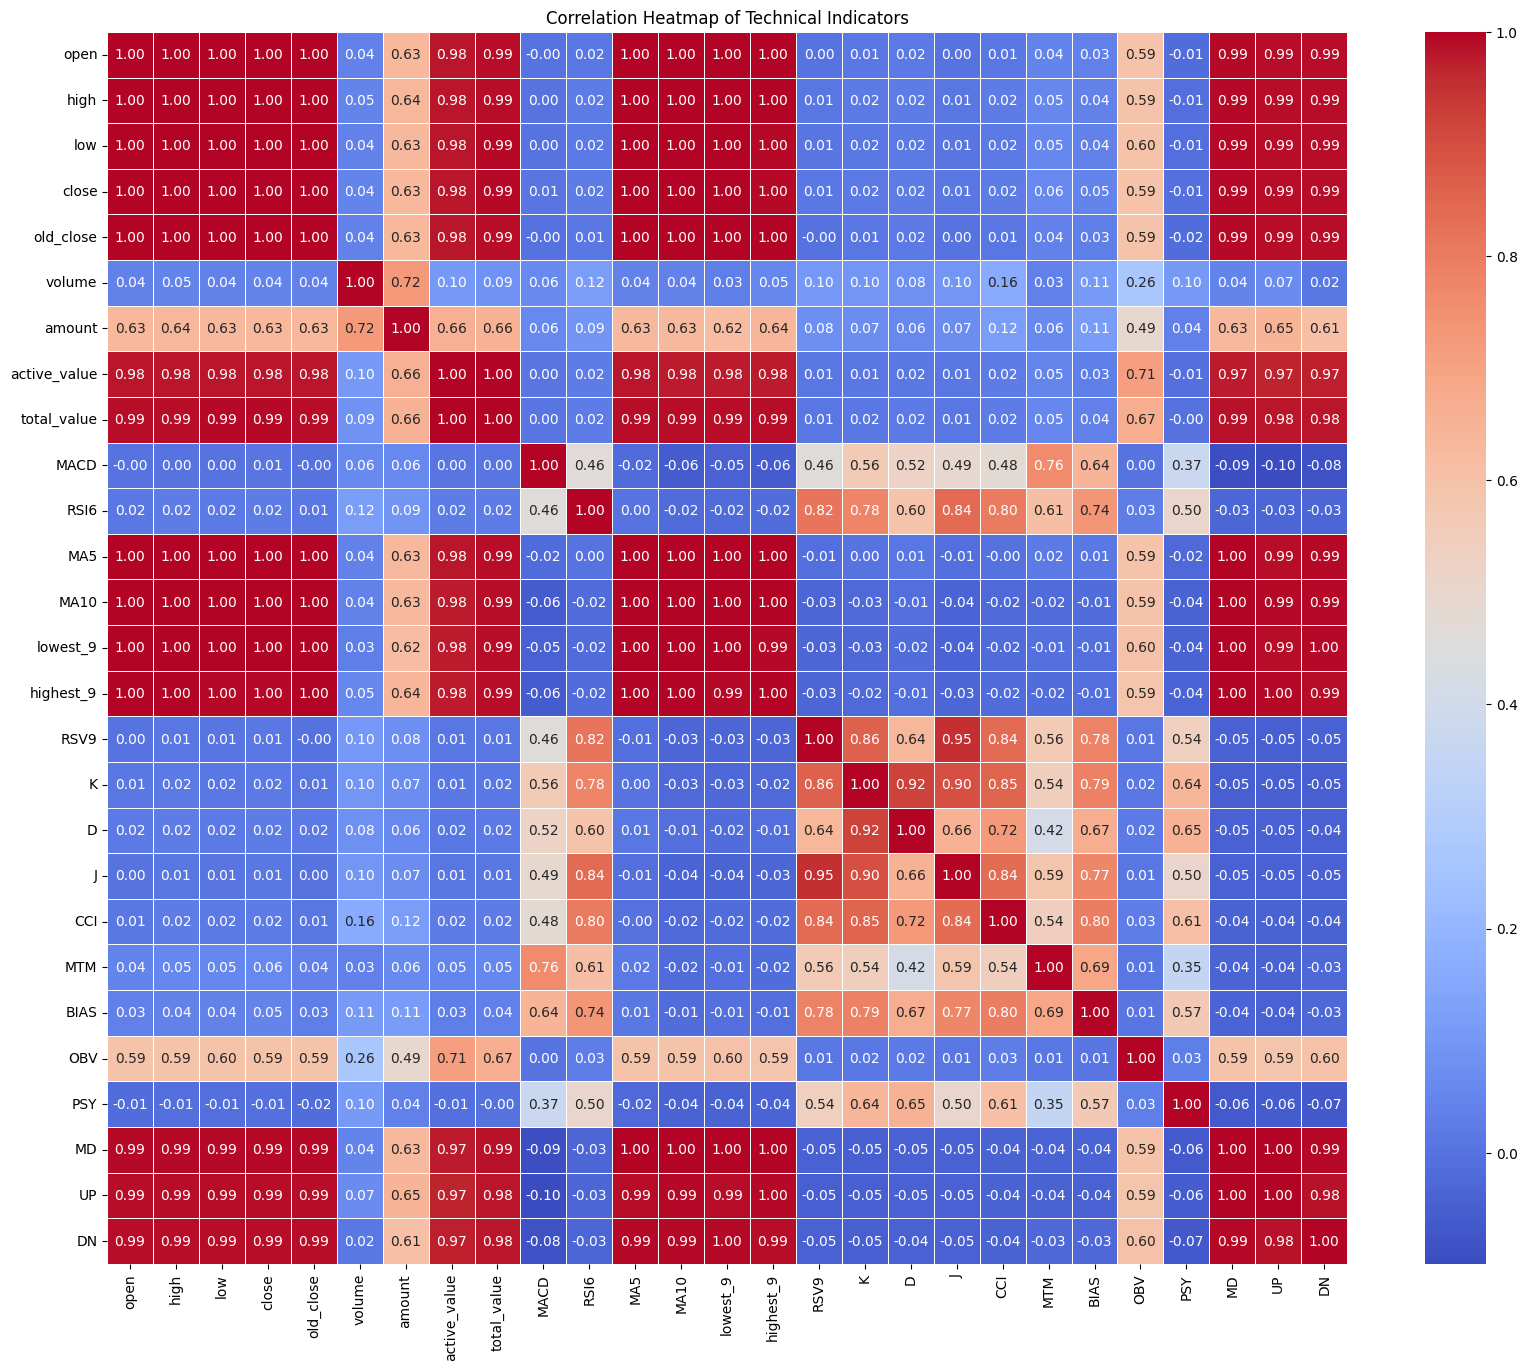

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# 对所有列进行归一化处理，将所有列的值归一化到 [0, 1]
df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 计算各指标之间的相关系数矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# 添加标题
plt.title("Correlation Heatmap of Technical Indicators")

# 显示图表
plt.show()